In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import cross_validate

In [24]:
movies = pd.read_csv('/kaggle/input/the-movies-dataset/ratings_small.csv',
                    usecols=["userId","movieId","rating","timestamp"])

## a. Read data

In [25]:
movies

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [26]:
data = pd.read_csv('/kaggle/input/the-movies-dataset/ratings_small.csv')
reader = Reader(line_format='user item rating timestamp', sep=',')
movies = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

## C. Compute the average MAE and RMSE of PMF, UserBased, ItemBased under 5-folds cross-validation

In [ ]:
# ======= Define models ===============
models = {
    "PMF": SVD(),
    "User based": KNNBasic(sim_options={'user_based': True}),
    "Item based": KNNBasic(sim_options={'user_based': False})
}
    

# ========= Perform cross validation ==========
for model_name, model in models.items():
    results = cross_validate(model, movies, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    avg_rmse = sum(results['test_rmse']) / len(results['test_rmse'])
    avg_mae = sum(results['test_mae']) / len(results['test_mae'])
    print("==============================")
    print(f"{model_name}:")
    print(f"average RMSE =  {avg_rmse}")
    print(f"average MAE =  {avg_mae}")
    print("==============================")

## D. Compare the average (mean) performances of User-based,item-based, PMF with respect to RMSE and MAE.

In [27]:
# ======= Define models ===============
models = {
    "PMF": SVD(),
    "User based": KNNBasic(sim_options={'user_based': True}),
    "Item based": KNNBasic(sim_options={'user_based': False})
}

# ======== store avg ==========
avg_rmse = {}
avg_mae = {}

# ======== cross validation=================
for model_name, model in models.items():
    results = cross_validate(model, movies, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    avg_rmse[model_name] = sum(results['test_rmse']) / len(results['test_rmse'])
    avg_mae[model_name] = sum(results['test_mae']) / len(results['test_mae'])
    
# ========== Compare the average performances ===========
for model_name in models:
    print("==============================")
    print(f"{model_name}:")
    print(f"Average RMSE = {avg_rmse[model_name]}")
    print(f"Average MAE = {avg_mae[model_name]}")
    print("==============================")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8939  0.8991  0.8873  0.9023  0.8969  0.8959  0.0051  
MAE (testset)     0.6903  0.6939  0.6824  0.6914  0.6939  0.6904  0.0042  
Fit time          1.46    1.54    1.50    1.49    1.51    1.50    0.03    
Test time         0.19    0.19    0.31    0.19    0.19    0.21    0.05    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9664  0.9687  0.9740  0.9710  0.9568  0.9674  0.0059

## E. Examine how the cosine, MSD  Pearson similarities impact the performances of User based, Item based. Plot your results

In [ ]:
# ======== Define models =================
user_cf_cosine = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})
user_cf_msd = KNNBasic(sim_options={'name': 'msd', 'user_based': True})
user_cf_pearson = KNNBasic(sim_options={'name': 'pearson', 'user_based': True})

item_cf_cosine = KNNBasic(sim_options={'name': 'cosine', 'user_based': False})
item_cf_msd = KNNBasic(sim_options={'name': 'msd', 'user_based': False})
item_cf_pearson = KNNBasic(sim_options={'name': 'pearson', 'user_based': False})

# ======== cross validation=================
user_cf_cosine_cv = cross_validate(user_cf_cosine, movies, measures=['MAE', 'RMSE'], cv=5, verbose=True)
user_cf_msd_cv = cross_validate(user_cf_msd, movies, measures=['MAE', 'RMSE'], cv=5, verbose=True)
user_cf_pearson_cv = cross_validate(user_cf_pearson, movies, measures=['MAE', 'RMSE'], cv=5, verbose=True)

item_cf_cosine_cv = cross_validate(item_cf_cosine, movies, measures=['MAE', 'RMSE'], cv=5, verbose=True)
item_cf_msd_cv = cross_validate(item_cf_msd, movies, measures=['MAE', 'RMSE'], cv=5, verbose=True)
item_cf_pearson_cv = cross_validate(item_cf_pearson, movies, measures=['MAE', 'RMSE'], cv=5, verbose=True)

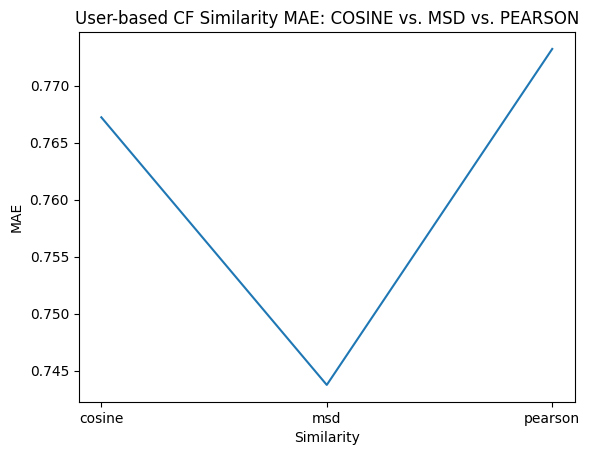

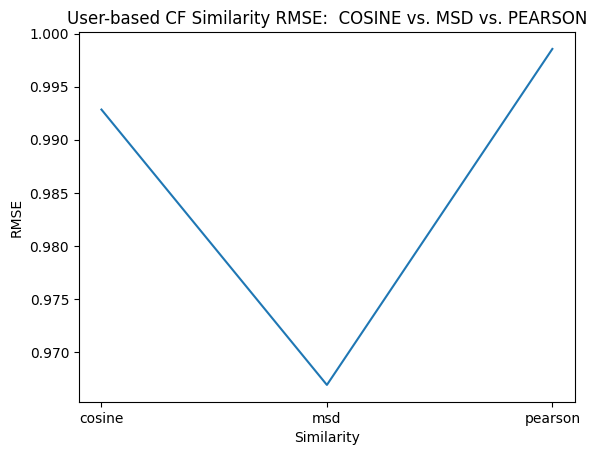

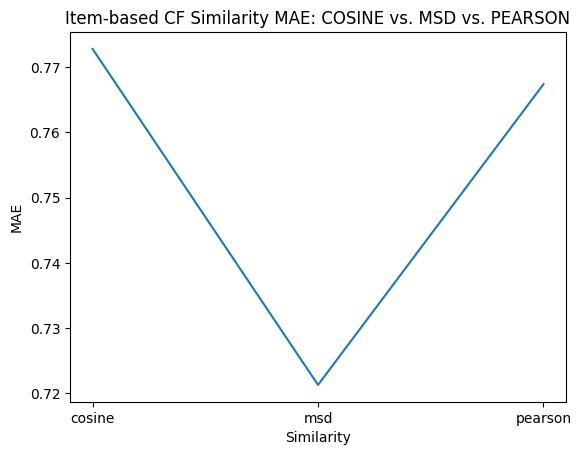

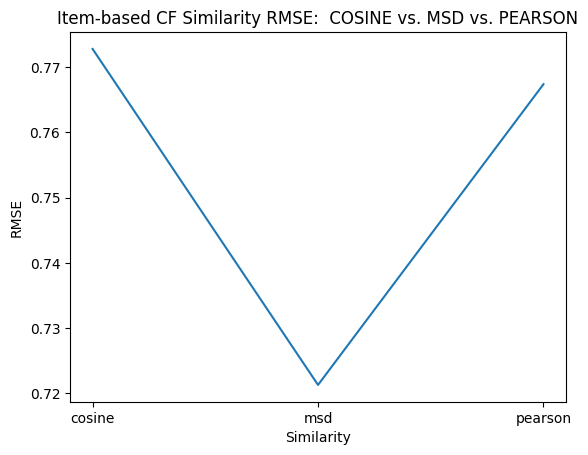

In [34]:
similarity_metrics = ['cosine', 'msd', 'pearson']

mae_val_user = [user_cf_cosine_cv['test_mae'].mean(), user_cf_msd_cv['test_mae'].mean(), user_cf_pearson_cv['test_mae'].mean()]
rmse_val_user = [user_cf_cosine_cv['test_rmse'].mean(), user_cf_msd_cv['test_rmse'].mean(), user_cf_pearson_cv['test_rmse'].mean()]

mae_val_item = [item_cf_cosine_cv['test_mae'].mean(), item_cf_msd_cv['test_mae'].mean(), item_cf_pearson_cv['test_mae'].mean()]
rmse_val_item = [item_cf_cosine_cv['test_rmse'].mean(), item_cf_msd_cv['test_rmse'].mean(), item_cf_pearson_cv['test_rmse'].mean()]

plt.plot(similarity_metrics, mae_val_user)
plt.title('User-based CF Similarity MAE: COSINE vs. MSD vs. PEARSON')
plt.xlabel('Similarity')
plt.ylabel('MAE')
plt.show()

plt.plot(similarity_metrics, rmse_val_user)
plt.title('User-based CF Similarity RMSE:  COSINE vs. MSD vs. PEARSON')
plt.xlabel('Similarity')
plt.ylabel('RMSE')
plt.show()


plt.plot(similarity_metrics, mae_val_item)
plt.title('Item-based CF Similarity MAE: COSINE vs. MSD vs. PEARSON')
plt.xlabel('Similarity')
plt.ylabel('MAE')
plt.show()

plt.plot(similarity_metrics, mae_val_item)
plt.title('Item-based CF Similarity RMSE:  COSINE vs. MSD vs. PEARSON')
plt.xlabel('Similarity')
plt.ylabel('RMSE')
plt.show()

## F. Examine how the number of neighbors impacts the performances of User based & Item based Collaborative Filtering? Plot your results.

In [ ]:
user_cf_Kval = range(1, 21, 1)
item_cf_Kval = range(1, 21, 1)

User_mae_values = []
User_rmse_values = []
Item_mae_values = []
Item_rmse_values = []


for k in user_cf_Kval:
    user_cf_k = KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
    user_cf_k_cv = cross_validate(user_cf_k, movies, measures=['MAE', 'RMSE'], cv=5, verbose=True)
    User_mae_values.append(user_cf_k_cv['test_mae'].mean())
    User_rmse_values.append(user_cf_k_cv['test_rmse'].mean())

for k in item_cf_Kval:
    item_cf_k = KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': False})
    item_cf_k_cv = cross_validate(item_cf_k, movies, measures=['MAE', 'RMSE'], cv=5, verbose=True)
    Item_mae_values.append(item_cf_k_cv['test_mae'].mean())
    Item_rmse_values.append(item_cf_k_cv['test_rmse'].mean())


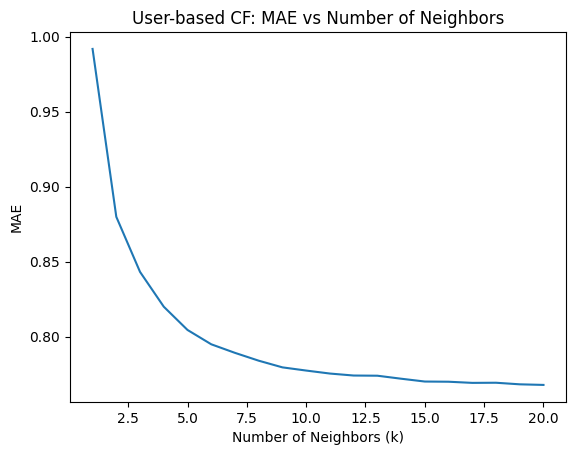

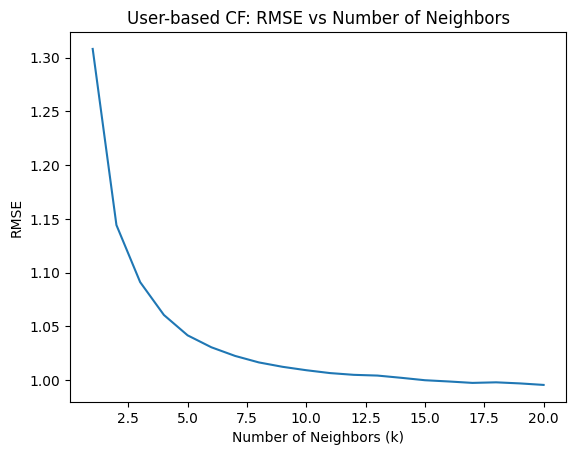

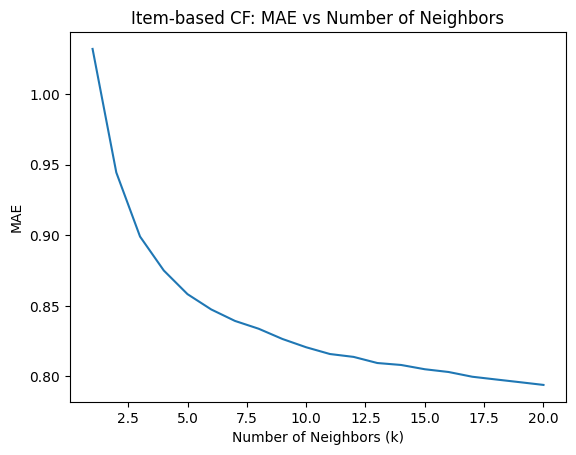

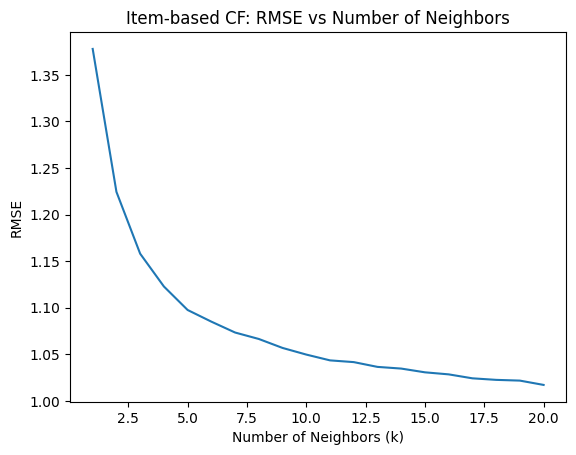

In [39]:
plt.plot(user_cf_Kval, User_mae_values)
plt.title('User-based CF: MAE vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('MAE')
plt.show()

plt.plot(user_cf_Kval, User_rmse_values)
plt.title('User-based CF: RMSE vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.show()

plt.plot(item_cf_Kval, Item_mae_values)
plt.title('Item-based CF: MAE vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('MAE')
plt.show()

plt.plot(item_cf_Kval, Item_rmse_values)
plt.title('Item-based CF: RMSE vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.show()

## G. Identify the best number of neighbor (denoted by K) for User/Item based in terms of RMSE. Is the best K of User based  the same with the best K of Item based?

In [43]:
best_k_user_cf = user_cf_Kval[np.argmin(User_rmse_values)]
print(f'User-based CF BNN (RMSE): {best_k_user_cf}')

best_k_item_cf = item_cf_Kval[np.argmin(Item_rmse_values)]
print(f'Item-based CF BNN (RMSE): {best_k_item_cf}')

User-based CF BNN (RMSE): 20
Item-based CF BNN (RMSE): 20
